In [1]:
import pandas as pd
import pathlib

import sys
sys.path.append("../utils")

In [2]:
cell_health_hash = "30ea5de393eb9cfc10b575582aa9f0f857b44c59"
cell_health_labels_link = f"https://raw.github.com/broadinstitute/cell-health/{cell_health_hash}/1.generate-profiles/data/consensus/cell_health_median.tsv.gz"

cell_health_labels = pd.read_csv(cell_health_labels_link, compression="gzip", sep="\t")
cell_health_labels

,Metadata_profile_id,Metadata_pert_name,Metadata_cell_line,cc_all_high_h2ax,cc_all_large_notround_polynuclear_mean,cc_all_large_round_polyploid_mean,cc_all_n_objects,cc_all_n_spots_h2ax_mean,cc_all_n_spots_h2ax_per_nucleus_area_mean,cc_all_nucleus_area_mean,...,vb_num_live_cells,vb_percent_all_apoptosis,vb_percent_caspase_dead_only,vb_percent_dead,vb_percent_dead_only,vb_percent_early_apoptosis,vb_percent_late_apoptosis,vb_percent_live,vb_ros_back_mean,vb_ros_mean
0,profile_0,AKT1-1,A549,0.008156,0.587977,0.018820,0.381501,0.176564,0.187675,-0.170616,...,0.399842,0.000000,-0.118976,-0.132871,-0.121090,0.000000,0.000000,0.132882,0.806970,1.293984
1,profile_1,AKT1-2,A549,0.056667,1.264627,0.241450,0.568443,0.235304,0.372684,-0.276888,...,0.101670,0.318027,0.621374,0.100032,0.074036,0.132751,0.467027,-0.099917,0.558041,1.151867
2,profile_2,ARID1B-1,A549,0.111163,1.092964,0.151393,0.290203,0.402121,0.481700,-0.276980,...,0.080701,0.339100,0.598093,0.055951,0.042014,0.165161,0.247058,-0.055920,-0.393937,0.103202
3,profile_3,ARID1B-2,A549,-0.061528,0.320829,-0.091007,0.141819,-0.378769,-0.288693,-0.108741,...,0.265754,0.098699,0.371930,-0.063935,-0.055160,0.138654,0.000000,0.063946,0.210005,0.055291
4,profile_4,ATF4-1,A549,3.967818,0.003400,3.268615,-2.246887,2.891737,2.878938,2.853995,...,-2.343919,0.000000,-0.089544,0.141535,0.131393,0.000000,0.000000,-0.141397,-0.631390,0.106477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,profile_352,TXN-2,HCC44,-0.342210,0.215623,0.375192,0.900283,-0.116349,-0.083793,0.207844,...,1.568620,-0.409888,0.148385,-0.519448,-0.372714,-0.136141,-0.502358,0.520090,0.182738,-0.116806
353,profile_353,XBP-1,HCC44,-0.247848,0.564827,-0.422787,0.780852,-0.074603,0.000000,-0.123090,...,0.344139,0.172909,0.839550,-0.212904,-0.245979,0.417994,0.028582,0.213691,0.245257,0.105633
354,profile_354,XBP-2,HCC44,-0.349572,-0.303116,-0.458782,0.434831,-0.157653,-0.058808,-0.404611,...,1.341318,-0.069684,0.540557,-0.146842,-0.288259,-0.179506,0.047976,0.147173,0.744648,0.023499
355,profile_355,YAP1-1,HCC44,-0.240422,0.408734,-0.351545,0.387100,-0.132059,0.002797,-0.059520,...,0.091803,-0.155056,-0.025451,-0.097891,-0.080691,-0.227172,-0.114292,0.098480,0.451868,0.127519


In [3]:
cell_health_data_hash = "4ee08b16f4b5c5266309a295b0a1697f0b9540b8"
plate_classifications_dir_link = f"https://github.com/WayScience/cell-health-data/raw/{cell_health_data_hash}/4.classify-features/plate_classifications"
plate_names = ["SQ00014610", "SQ00014611", "SQ00014612", "SQ00014613", "SQ00014614", "SQ00014615", "SQ00014616", "SQ00014617", "SQ00014618"]

cell_line_plates = {
    "A549": ["SQ00014610", "SQ00014611", "SQ00014612"],
    "ES2": ["SQ00014613", "SQ00014614", "SQ00014615"],
    "HCC44": ["SQ00014616", "SQ00014617", "SQ00014618"],
}

In [4]:
def create_classification_profiles(plate_classifications_dir_link: str, cell_line_plates: dict) -> pd.DataFrame:
    cell_line_classification_profiles = []
    
    for cell_line in cell_line_plates:
        print(f"Creating classification profiles for cell line {cell_line}")
        # create one large dataframe for all 3 plates in the particular cell line 
        cell_line_plate_names = cell_line_plates[cell_line]
        cell_line_plate_classifications = []
        for cell_line_plate_name in cell_line_plate_names:
            print(f"Loading plate {cell_line_plate_name}")
            plate_classifications_link = f"{plate_classifications_dir_link}/{cell_line_plate_name}_cell_classifications.csv.gz"
            plate_classifications = pd.read_csv(plate_classifications_link, compression="gzip", index_col=0)
            cell_line_plate_classifications.append(plate_classifications)
        cell_line_plate_classifications = pd.concat(cell_line_plate_classifications, axis=0).reset_index(drop=True)
        
        # create dataframe with cell classifications averaged across pertubation, include cell line metadata
        print("Averaging classification across perturbation metadata...")
        # add cell line metadata, rename pertubation column
        cell_line_plate_classifications["Metadata_cell_line"] = cell_line
        cell_line_plate_classifications = cell_line_plate_classifications.rename(columns={"Metadata_Reagent": "Metadata_pert_name"})
        
        # get rid of extra metadata columns
        phenotypic_classes = [col for col in cell_line_plate_classifications.columns.tolist() if "Metadata" not in col]
        phenotypic_classes.remove("Location_Center_X")
        phenotypic_classes.remove("Location_Center_Y")
        columns_to_keep = ["Metadata_pert_name", "Metadata_cell_line"] + phenotypic_classes
        cell_line_plate_classifications = cell_line_plate_classifications[columns_to_keep]
        
        # average across pertubation
        cell_line_classification_profile = cell_line_plate_classifications.groupby(["Metadata_pert_name", "Metadata_cell_line"]).mean()
        cell_line_classification_profiles.append(cell_line_classification_profile)
    
    return pd.concat(cell_line_classification_profiles, axis=0).reset_index(level=["Metadata_pert_name", "Metadata_cell_line"])


test = create_classification_profiles(plate_classifications_dir_link, cell_line_plates)
test

Creating classification profiles for cell line A549
Loading plate SQ00014610
Loading plate SQ00014611
Loading plate SQ00014612
Averaging classification across perturbation metadata...
Creating classification profiles for cell line ES2
Loading plate SQ00014613
Loading plate SQ00014614
Loading plate SQ00014615
Averaging classification across perturbation metadata...
Creating classification profiles for cell line HCC44
Loading plate SQ00014616
Loading plate SQ00014617
Loading plate SQ00014618
Averaging classification across perturbation metadata...


,Metadata_pert_name,Metadata_cell_line,ADCCM,Anaphase,Apoptosis,Artefact,Binuclear,Elongated,Grape,Hole,Interphase,Large,Metaphase,MetaphaseAlignment,OutOfFocus,Polylobed,Prometaphase,SmallIrregular
0,AKT1-1,A549,0.054932,0.027755,0.021307,0.048169,0.116542,0.027095,0.040155,0.030093,0.221322,0.019687,0.040099,0.037670,0.098610,0.129647,0.041857,0.045061
1,AKT1-2,A549,0.052757,0.026695,0.022417,0.047275,0.113333,0.026610,0.041179,0.034239,0.233669,0.021312,0.039802,0.036686,0.089843,0.128045,0.041199,0.044936
2,ARID1B-1,A549,0.040267,0.028365,0.021202,0.047656,0.119522,0.024333,0.039460,0.035141,0.290153,0.028437,0.035434,0.040248,0.044184,0.136870,0.033468,0.035259
3,ARID1B-2,A549,0.045109,0.030562,0.021584,0.041333,0.123428,0.027050,0.039057,0.028491,0.293695,0.026684,0.033261,0.043536,0.045784,0.124731,0.036990,0.038706
4,ATF4-1,A549,0.026970,0.035827,0.016918,0.013856,0.090874,0.028103,0.019467,0.016642,0.508466,0.039001,0.016502,0.052635,0.012241,0.061432,0.035789,0.025276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,XBP-1,HCC44,0.032277,0.027736,0.029891,0.053386,0.107091,0.041403,0.038645,0.041323,0.282075,0.041348,0.033903,0.048170,0.044153,0.108327,0.035608,0.034663
353,XBP-2,HCC44,0.032669,0.029002,0.031823,0.054948,0.106691,0.039883,0.036857,0.046972,0.265102,0.041838,0.035828,0.047439,0.045634,0.112850,0.035914,0.036549
354,YAP1-1,HCC44,0.034511,0.027847,0.037634,0.050009,0.087623,0.043881,0.047348,0.056616,0.191724,0.036977,0.032514,0.039765,0.137421,0.088149,0.047577,0.040405
355,YAP1-2,HCC44,0.033771,0.028334,0.030037,0.056260,0.105229,0.038985,0.033854,0.043182,0.256354,0.042508,0.036015,0.045088,0.074877,0.092741,0.042136,0.040629


In [5]:
final_profile_matrix = pd.merge(cell_health_labels, test, on=["Metadata_pert_name", "Metadata_cell_line"]) #DOESNT MERGE CONTROLS
final_profile_matrix

,Metadata_profile_id,Metadata_pert_name,Metadata_cell_line,cc_all_high_h2ax,cc_all_large_notround_polynuclear_mean,cc_all_large_round_polyploid_mean,cc_all_n_objects,cc_all_n_spots_h2ax_mean,cc_all_n_spots_h2ax_per_nucleus_area_mean,cc_all_nucleus_area_mean,...,Grape,Hole,Interphase,Large,Metaphase,MetaphaseAlignment,OutOfFocus,Polylobed,Prometaphase,SmallIrregular
0,profile_0,AKT1-1,A549,0.008156,0.587977,0.018820,0.381501,0.176564,0.187675,-0.170616,...,0.040155,0.030093,0.221322,0.019687,0.040099,0.037670,0.098610,0.129647,0.041857,0.045061
1,profile_1,AKT1-2,A549,0.056667,1.264627,0.241450,0.568443,0.235304,0.372684,-0.276888,...,0.041179,0.034239,0.233669,0.021312,0.039802,0.036686,0.089843,0.128045,0.041199,0.044936
2,profile_2,ARID1B-1,A549,0.111163,1.092964,0.151393,0.290203,0.402121,0.481700,-0.276980,...,0.039460,0.035141,0.290153,0.028437,0.035434,0.040248,0.044184,0.136870,0.033468,0.035259
3,profile_3,ARID1B-2,A549,-0.061528,0.320829,-0.091007,0.141819,-0.378769,-0.288693,-0.108741,...,0.039057,0.028491,0.293695,0.026684,0.033261,0.043536,0.045784,0.124731,0.036990,0.038706
4,profile_4,ATF4-1,A549,3.967818,0.003400,3.268615,-2.246887,2.891737,2.878938,2.853995,...,0.019467,0.016642,0.508466,0.039001,0.016502,0.052635,0.012241,0.061432,0.035789,0.025276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,profile_352,TXN-2,HCC44,-0.342210,0.215623,0.375192,0.900283,-0.116349,-0.083793,0.207844,...,0.042297,0.045487,0.242511,0.044597,0.034945,0.048240,0.061386,0.106988,0.041195,0.040591
350,profile_353,XBP-1,HCC44,-0.247848,0.564827,-0.422787,0.780852,-0.074603,0.000000,-0.123090,...,0.038645,0.041323,0.282075,0.041348,0.033903,0.048170,0.044153,0.108327,0.035608,0.034663
351,profile_354,XBP-2,HCC44,-0.349572,-0.303116,-0.458782,0.434831,-0.157653,-0.058808,-0.404611,...,0.036857,0.046972,0.265102,0.041838,0.035828,0.047439,0.045634,0.112850,0.035914,0.036549
352,profile_355,YAP1-1,HCC44,-0.240422,0.408734,-0.351545,0.387100,-0.132059,0.002797,-0.059520,...,0.047348,0.056616,0.191724,0.036977,0.032514,0.039765,0.137421,0.088149,0.047577,0.040405


In [6]:
pearson_corr = final_profile_matrix.corr(method="pearson")
pearson_corr

,cc_all_high_h2ax,cc_all_large_notround_polynuclear_mean,cc_all_large_round_polyploid_mean,cc_all_n_objects,cc_all_n_spots_h2ax_mean,cc_all_n_spots_h2ax_per_nucleus_area_mean,cc_all_nucleus_area_mean,cc_all_nucleus_roundness_mean,cc_cc_early_mitosis,cc_cc_g1,...,Grape,Hole,Interphase,Large,Metaphase,MetaphaseAlignment,OutOfFocus,Polylobed,Prometaphase,SmallIrregular
cc_all_high_h2ax,1.000000,0.086975,0.279427,-0.366115,0.883626,0.791566,0.585233,-0.001469,0.160269,0.310411,...,-0.057424,-0.210902,0.190453,0.328771,-0.350037,0.149609,-0.234886,0.157100,-0.126545,-0.314587
cc_all_large_notround_polynuclear_mean,0.086975,1.000000,0.639305,-0.095104,-0.017665,0.065630,0.127687,-0.156300,0.063702,-0.339784,...,0.121300,-0.152301,-0.099025,-0.191034,0.013088,-0.099144,0.123815,0.248893,0.055251,0.114175
cc_all_large_round_polyploid_mean,0.279427,0.639305,1.000000,-0.359795,0.145951,0.206667,0.431131,-0.011344,0.081306,-0.320750,...,-0.015104,-0.229881,0.147329,-0.063543,-0.206631,0.090006,-0.036629,-0.001262,0.037634,0.036335
cc_all_n_objects,-0.366115,-0.095104,-0.359795,1.000000,-0.211933,-0.291577,-0.228722,0.309824,-0.391498,-0.189312,...,-0.139966,0.547522,-0.240432,-0.129084,0.589061,-0.544299,0.321083,0.151967,-0.496766,0.225104
cc_all_n_spots_h2ax_mean,0.883626,-0.017665,0.145951,-0.211933,1.000000,0.910023,0.599013,0.293436,0.095129,0.429594,...,-0.122348,-0.124483,0.257930,0.395740,-0.316185,0.123723,-0.271855,0.140417,-0.283951,-0.366781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MetaphaseAlignment,0.149609,-0.099144,0.090006,-0.544299,0.123723,0.159477,0.089758,-0.118341,0.127598,0.180000,...,0.315054,-0.408744,0.350739,0.112552,-0.580860,1.000000,-0.482481,-0.196279,0.383974,-0.422325
OutOfFocus,-0.234886,0.123815,-0.036629,0.321083,-0.271855,-0.292151,-0.291511,0.001634,-0.031935,-0.327786,...,0.139183,0.539383,-0.638051,-0.186372,0.475071,-0.482481,1.000000,0.082176,0.019893,0.363440
Polylobed,0.157100,0.248893,-0.001262,0.151967,0.140417,0.118893,0.065135,-0.173118,0.043008,0.001130,...,0.310221,-0.015356,-0.322753,0.203241,-0.002087,-0.196279,0.082176,1.000000,-0.229438,-0.325259
Prometaphase,-0.126545,0.055251,0.037634,-0.496766,-0.283951,-0.166919,-0.282391,-0.468121,0.317046,0.012005,...,0.403243,-0.259645,-0.358756,0.018408,-0.125657,0.383974,0.019893,-0.229438,1.000000,0.226001


In [27]:
pearson_graph = pearson_corr.iloc[70:, :70]
pearson_graph

,cc_all_high_h2ax,cc_all_large_notround_polynuclear_mean,cc_all_large_round_polyploid_mean,cc_all_n_objects,cc_all_n_spots_h2ax_mean,cc_all_n_spots_h2ax_per_nucleus_area_mean,cc_all_nucleus_area_mean,cc_all_nucleus_roundness_mean,cc_cc_early_mitosis,cc_cc_g1,...,vb_num_live_cells,vb_percent_all_apoptosis,vb_percent_caspase_dead_only,vb_percent_dead,vb_percent_dead_only,vb_percent_early_apoptosis,vb_percent_late_apoptosis,vb_percent_live,vb_ros_back_mean,vb_ros_mean
ADCCM,-0.337789,0.265126,0.033389,0.201428,-0.382747,-0.311100,-0.451305,-0.048172,0.052876,-0.346027,...,0.179827,-0.053367,0.091412,-0.071492,-0.086092,-0.101412,-0.032454,0.071314,0.144082,0.159362
Anaphase,0.144667,-0.084986,0.022485,-0.139921,0.245759,0.215246,0.119519,0.299517,-0.084334,0.188527,...,-0.125131,-0.067313,0.030612,-0.110309,-0.096419,0.061478,-0.118088,0.110421,-0.148582,-0.152158
Apoptosis,-0.055775,-0.082291,-0.094401,-0.279267,-0.219901,-0.180086,-0.155887,-0.471760,0.186604,-0.031696,...,-0.277787,0.469417,0.004191,0.508295,0.462251,0.125356,0.521341,-0.508478,0.407874,0.393379
Artefact,-0.253924,0.102005,-0.045230,0.347244,-0.304395,-0.315401,-0.319368,-0.036429,-0.001999,-0.411061,...,0.374241,-0.089161,0.033442,-0.109695,-0.149828,-0.115221,-0.053740,0.109361,0.141849,0.023579
Binuclear,0.023016,-0.023572,-0.094984,0.451348,0.115929,0.039122,0.187919,0.270967,-0.206551,-0.063586,...,0.432271,-0.278257,0.001029,-0.361525,-0.409793,-0.149182,-0.297547,0.361535,0.066211,-0.042195
Elongated,0.070277,-0.173309,-0.184691,-0.311034,0.014507,0.024355,-0.111585,-0.338778,0.218554,0.278573,...,-0.246591,0.176885,-0.153784,0.233219,0.240904,0.083573,0.219666,-0.232966,-0.185132,-0.092587
Grape,-0.057424,0.121300,-0.015104,-0.139966,-0.122348,-0.108244,-0.195927,-0.329031,0.099698,-0.055955,...,-0.090201,0.089336,-0.013504,0.168096,0.192070,0.078510,0.139979,-0.168130,-0.275567,-0.189778
Hole,-0.210902,-0.152301,-0.229881,0.547522,-0.124483,-0.160858,-0.140770,0.221869,-0.244010,-0.172782,...,0.554407,-0.287654,0.004914,-0.330840,-0.363794,-0.193112,-0.266970,0.331095,0.082692,-0.074402
Interphase,0.190453,-0.099025,0.147329,-0.240432,0.257930,0.241202,0.278351,0.252315,-0.036393,0.218524,...,-0.273655,0.013652,0.035058,0.006601,0.037192,0.103225,-0.048740,-0.006437,-0.170593,-0.100477
Large,0.328771,-0.191034,-0.063543,-0.129084,0.395740,0.413364,0.483651,-0.016765,-0.060402,0.432824,...,-0.075216,-0.117426,-0.213837,-0.087193,-0.039539,-0.059731,-0.103970,0.087339,-0.033064,-0.152589


<AxesSubplot:>

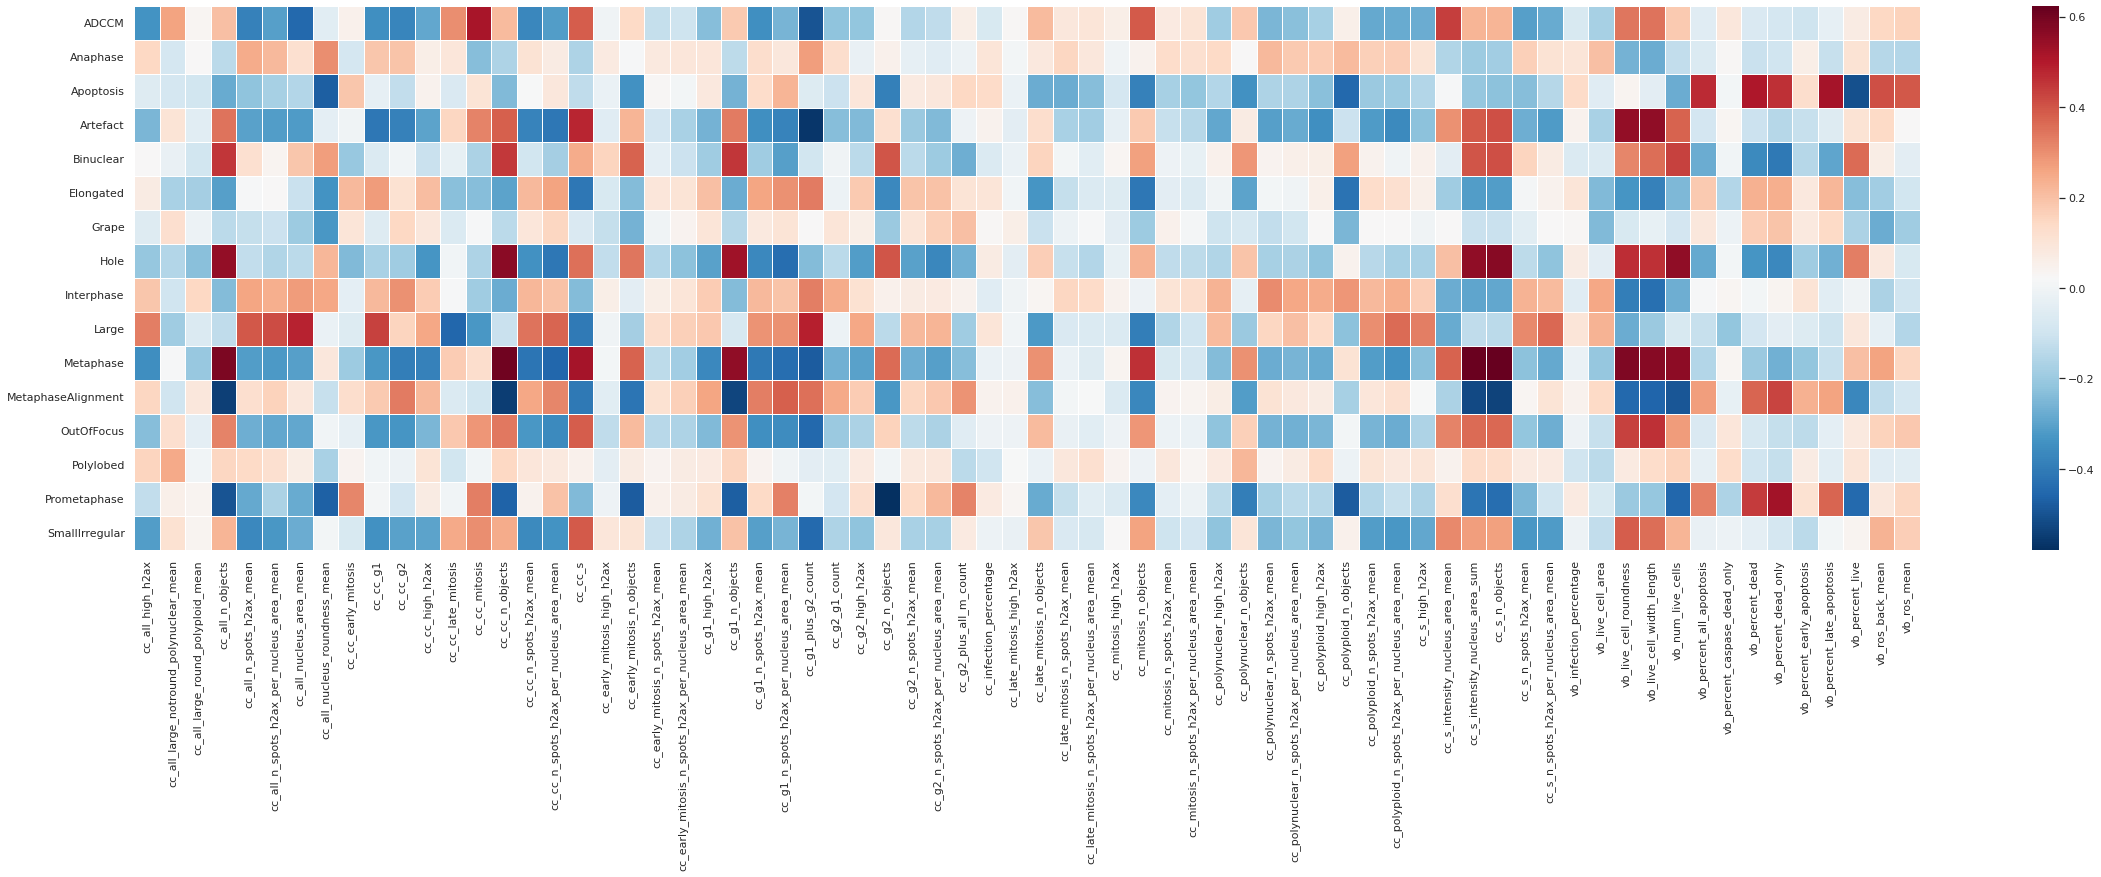

In [29]:
import seaborn as sns

sns.set(rc={'figure.figsize':(40,10)})

sns.heatmap(pearson_graph, 
            xticklabels=pearson_graph.columns,
            yticklabels=pearson_graph.index,
            cmap='RdBu_r',
            linewidth=0.5)